In [1]:
!pip install tensorflow matplotlib numpy opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00


In [2]:
!unzip /content/UCMerced_LandUse.zip

Archive:  /content/UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural04.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural05.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural06.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural07.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural09.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural10.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural11.tif  
  inflating: UCMerc

In [3]:
import os
import shutil
import random

DATASET_PATH = "/content/UCMerced_LandUse/Images"
TRAIN_DIR = "/content/UCMerced_LandUse/train"
TEST_DIR = "/content/UCMerced_LandUse/test"

# Create train/test folders
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)

# Get all category folders
categories = [folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))]

# Split images into train/test .8/.2
for category in categories:
    category_path = os.path.join(DATASET_PATH, category)
    images = [img for img in os.listdir(category_path) if img.endswith(".tif")]

    random.shuffle(images)
    split_idx = int(0.8 * len(images))

    train_images = images[:split_idx]
    test_images = images[split_idx:]

    os.makedirs(os.path.join(TRAIN_DIR, category), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, category), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(TRAIN_DIR, category, img))

    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(TEST_DIR, category, img))

print("Train/Test folders created ")


Train/Test folders created 


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32

# Data Augmentation & Normalization
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, rotation_range=10, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)

num_classes = len(train_generator.class_indices)  # For number of classes
print(f" Number of Classes: {num_classes}")


Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
 Number of Classes: 21


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3), name="conv2d_1"),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu", name="conv2d_2"),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu", name="conv2d_3"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adagrad", loss="categorical_crossentropy", metrics=["accuracy"])

print("CNN Model Created!")
model.summary()


CNN Model Created!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,349 (12.62 MB)

 Trainable params: 3,307,349 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
losses = {}  # dictionary to store losses

for epochs in [100]:# Earlier taken 10, 25,50,100,200. Satifactory distinction at 100
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator
    )
    # store training loss for current epoch setting
    losses[f"loss_{epochs}"] = history.history['loss']

print("Training Completed!")
print(losses)  # you can access losses for a specific epoch like losses["loss_10"]


Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 812ms/step - accuracy: 0.0646 - loss: 3.0479 - val_accuracy: 0.0286 - val_loss: 3.0417
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 806ms/step - accuracy: 0.0420 - loss: 3.0407 - val_accuracy: 0.0405 - val_loss: 3.0364
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 810ms/step - accuracy: 0.0519 - loss: 3.0350 - val_accuracy: 0.0476 - val_loss: 3.0336
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 796ms/step - accuracy: 0.0615 - loss: 3.0369 - val_accuracy: 0.0452 - val_loss: 3.0297
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 800ms/step - accuracy: 0.0499 - loss: 3.0328 - val_accuracy: 0.0452 - val_loss: 3.0266
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 800ms/step - accuracy: 0.0548 - loss: 3.0295 - val_accuracy: 0.0524 - val_loss: 3.0235
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 796ms/step - accuracy: 0.0514 - loss: 3.0289 - val_accuracy: 0.0524 - val_loss: 3.0204
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 794ms/step - accuracy: 0.0627 - loss: 3.0224 - 

In [16]:
#Saved manually after each iteration with a different optimizer
l_100_adam = [0.37248000502586365, 0.3463388979434967, 0.3213031589984894, 0.3229065537452698, 0.30721136927604675, 0.284591943025589, 0.30029037594795227, 0.3386796712875366, 0.3367518186569214, 0.2599000334739685, 0.28573837876319885, 0.26126399636268616, 0.3145185112953186, 0.33451011776924133, 0.27017688751220703, 0.249220609664917, 0.2859231233596802, 0.294663667678833, 0.26384255290031433, 0.25404036045074463, 0.2727704644203186, 0.26412883400917053, 0.2670113742351532, 0.2822500467300415, 0.24894367158412933, 0.25576937198638916, 0.30781644582748413, 0.26961612701416016, 0.21206504106521606, 0.19960328936576843, 0.2000911682844162, 0.2388666272163391, 0.25893065333366394, 0.23466183245182037, 0.2195429801940918, 0.2450629472732544, 0.21797196567058563, 0.21799704432487488, 0.2107010930776596, 0.3154849708080292, 0.18961507081985474, 0.2035142332315445, 0.23624321818351746, 0.2170339971780777, 0.2347983568906784, 0.22407978773117065, 0.20346160233020782, 0.23316684365272522, 0.17070172727108002, 0.19502781331539154, 0.21283546090126038, 0.21564000844955444, 0.17075803875923157, 0.19301284849643707, 0.190498948097229, 0.20042851567268372, 0.20091435313224792, 0.1919897198677063, 0.19395115971565247, 0.2110465168952942, 0.19874268770217896, 0.20162580907344818, 0.20208348333835602, 0.15907986462116241, 0.19883282482624054, 0.181560218334198, 0.14698275923728943, 0.18876922130584717, 0.2036433219909668, 0.13382281363010406, 0.187644362449646, 0.14365527033805847, 0.1627349704504013, 0.1732117235660553, 0.1467641443014145, 0.1404743641614914, 0.18906816840171814, 0.2105642408132553, 0.20208340883255005, 0.1586192399263382, 0.2072855681180954, 0.21763792634010315, 0.20545995235443115, 0.1616355925798416, 0.1410798728466034, 0.16987797617912292, 0.20555520057678223, 0.16372373700141907, 0.13322055339813232, 0.13525694608688354, 0.11477715522050858, 0.14150919020175934, 0.18214060366153717, 0.20390866696834564, 0.13752877712249756, 0.14116472005844116, 0.14578239619731903, 0.17663206160068512, 0.1581406593322754, 0.17158319056034088]
l_100_adamW = [3.0140089988708496, 2.836674928665161, 2.5590219497680664, 2.405705690383911, 2.294599771499634, 2.167930841445923, 2.0582430362701416, 1.9044759273529053, 1.7822692394256592, 1.6579078435897827, 1.6098312139511108, 1.513538122177124, 1.4322423934936523, 1.3580307960510254, 1.3633078336715698, 1.243201732635498, 1.1688989400863647, 1.1168158054351807, 1.1102098226547241, 1.084679126739502, 1.0112781524658203, 0.9630581140518188, 0.9863678812980652, 0.8962439298629761, 0.8673376441001892, 0.873297393321991, 0.8158445954322815, 0.8701042532920837, 0.8047556281089783, 0.733964741230011, 0.7658852934837341, 0.7160336971282959, 0.7749086618423462, 0.6264208555221558, 0.6883828043937683, 0.6818543076515198, 0.6716859340667725, 0.6021932363510132, 0.622967541217804, 0.6017285585403442, 0.593966543674469, 0.574745237827301, 0.5283718109130859, 0.5263550281524658, 0.5248222351074219, 0.5134122371673584, 0.5078064799308777, 0.5377137064933777, 0.4833814799785614, 0.4787676930427551, 0.5595481395721436, 0.5061705708503723, 0.4736139178276062, 0.41607606410980225, 0.42534902691841125, 0.4230772852897644, 0.3862970769405365, 0.40023818612098694, 0.43590447306632996, 0.4279273748397827, 0.42792168259620667, 0.40503621101379395, 0.41420087218284607, 0.37716180086135864, 0.36679428815841675, 0.4107513129711151, 0.4101186990737915, 0.334615558385849, 0.38210129737854004, 0.4063839614391327, 0.43056318163871765, 0.36191943287849426, 0.39489665627479553, 0.31343725323677063, 0.3355604410171509, 0.2792406380176544, 0.2716890871524811, 0.310597687959671, 0.3286018669605255, 0.28904685378074646, 0.31443750858306885, 0.30695971846580505, 0.2819916009902954, 0.259190171957016, 0.32632166147232056, 0.31350138783454895, 0.30980145931243896, 0.2569742798805237, 0.32000577449798584, 0.37616685032844543, 0.2657248079776764, 0.27435120940208435, 0.3108137249946594, 0.34003549814224243, 0.2683795988559723, 0.29542461037635803, 0.2740728259086609, 0.24521659314632416, 0.22469253838062286, 0.21296168863773346]
l_100_RMSprop = [2.617791175842285, 2.5136325359344482, 2.343858242034912, 1.9993575811386108, 2.755040168762207, 1.8828202486038208, 1.5943537950515747, 1.6360688209533691, 1.5000501871109009, 1.312976598739624, 1.3686621189117432, 1.2882874011993408, 1.1547707319259644, 1.4050590991973877, 1.2483181953430176, 1.2619388103485107, 0.9727098941802979, 0.9929388761520386, 0.958532989025116, 0.8716776371002197, 0.8857120871543884, 1.0476278066635132, 1.338432788848877, 0.8883576989173889, 1.0225111246109009, 1.0388391017913818, 1.0110989809036255, 0.9866976737976074, 0.8984487056732178, 1.0154633522033691, 0.7985425591468811, 0.7865878939628601, 0.9180407524108887, 1.139218807220459, 0.994397759437561, 0.8887077569961548, 0.976138174533844, 0.9070858359336853, 1.0264465808868408, 0.9741034507751465, 0.8872427344322205, 1.4170547723770142, 0.9880743622779846, 0.8608747124671936, 0.9461686611175537, 1.112923264503479, 0.9183954000473022, 0.841343343257904, 1.0104106664657593, 1.0042442083358765, 1.1317940950393677, 0.9209041595458984, 0.9293625354766846, 0.9316379427909851, 0.8686315417289734, 1.0733131170272827, 1.0934250354766846, 1.5655354261398315, 0.9242006540298462, 1.1088393926620483, 0.8844091296195984, 1.298227310180664, 1.498781442642212, 0.8762085437774658, 0.8764982223510742, 3.766702890396118, 0.9560301303863525, 1.0538605451583862, 0.9946579933166504, 1.0532478094100952, 0.9983769655227661, 0.9409992098808289, 1.0921717882156372, 1.2265020608901978, 1.0459799766540527, 1.2538158893585205, 1.4125412702560425, 0.9984540939331055, 1.1228461265563965, 1.7332390546798706, 1.0239167213439941, 0.8876243233680725, 1.3444145917892456, 1.025521159172058, 1.1456528902053833, 1.148032307624817, 1.3481175899505615, 1.5362765789031982, 1.3654855489730835, 1.1690739393234253, 1.2221468687057495, 1.4098174571990967, 1.112051248550415, 1.1720908880233765, 1.6867321729660034, 1.3548014163970947, 1.4795056581497192, 1.0754544734954834, 1.1809309720993042, 0.20795462228956856]
l_100_SGD = [3.0434277057647705, 3.0409927368164062, 3.0392911434173584, 3.037532329559326, 3.0362260341644287, 3.0348446369171143, 3.0337748527526855, 3.0329136848449707, 3.031992197036743, 3.031031370162964, 3.030461311340332, 3.0296154022216797, 3.0287227630615234, 3.0279557704925537, 3.026592254638672, 3.0252394676208496, 3.0244662761688232, 3.0233535766601562, 3.0224108695983887, 3.0210530757904053, 3.0200822353363037, 3.018932580947876, 3.017690896987915, 3.0161798000335693, 3.01509952545166, 3.0137765407562256, 3.012310028076172, 3.010690450668335, 3.0088863372802734, 3.0068199634552, 3.0050063133239746, 3.0030229091644287, 3.001655101776123, 2.999274730682373, 2.9977307319641113, 2.994192361831665, 2.9925432205200195, 2.989297389984131, 2.9869091510772705, 2.9849319458007812, 2.9814774990081787, 2.9786365032196045, 2.9743189811706543, 2.9714488983154297, 2.96814227104187, 2.963364362716675, 2.9590094089508057, 2.9552414417266846, 2.949082136154175, 2.946338415145874, 2.943560838699341, 2.9371559619903564, 2.932297945022583, 2.9286839962005615, 2.92097544670105, 2.9131295680999756, 2.906832456588745, 2.901062250137329, 2.899355173110962, 2.8880844116210938, 2.878131151199341, 2.8743574619293213, 2.865368366241455, 2.8620529174804688, 2.851231813430786, 2.8481264114379883, 2.833503007888794, 2.823316812515259, 2.8131444454193115, 2.808098793029785, 2.8010640144348145, 2.7849788665771484, 2.786036491394043, 2.770315647125244, 2.761183977127075, 2.752772092819214, 2.740633726119995, 2.7359328269958496, 2.7178196907043457, 2.7407150268554688, 2.7089600563049316, 2.6903598308563232, 2.6972577571868896, 2.6717050075531006, 2.663891553878784, 2.653721809387207, 2.635740041732788, 2.667666435241699, 2.630509376525879, 2.627553701400757, 2.613476276397705, 2.588134288787842, 2.580425262451172, 2.5635385513305664, 2.5558550357818604, 2.545146942138672, 2.5291759967803955, 2.531100273132324, 2.5592665672302246, 2.4915053844451904]
l_100_SGD_Momentum = [3.0328116416931152, 3.026160717010498, 3.0168511867523193, 3.001126289367676, 2.9866607189178467, 2.961984872817993, 2.9263315200805664, 2.876251459121704, 2.803032875061035, 2.726278781890869, 2.6668076515197754, 2.612839460372925, 2.523387908935547, 2.3189144134521484, 2.2717432975769043, 2.2536137104034424, 2.182685852050781, 2.164769411087036, 2.0825469493865967, 2.177672863006592, 1.9853814840316772, 1.8930803537368774, 1.8861302137374878, 1.8985772132873535, 1.878082036972046, 1.7980095148086548, 1.8668898344039917, 1.8609681129455566, 1.7675727605819702, 1.6740370988845825, 1.696800708770752, 1.7353414297103882, 1.6772273778915405, 1.6791954040527344, 1.5988506078720093, 1.5170613527297974, 1.5676872730255127, 1.511067271232605, 1.620849609375, 1.46729576587677, 1.5897202491760254, 1.4800182580947876, 1.4519730806350708, 1.6278475522994995, 1.4308463335037231, 1.3562712669372559, 1.4304922819137573, 1.4391332864761353, 1.3644309043884277, 1.4272679090499878, 1.4747360944747925, 1.3425904512405396, 1.408055067062378, 1.407168984413147, 1.2817915678024292, 1.306643009185791, 1.340827465057373, 1.4182873964309692, 1.534480333328247, 1.2952880859375, 1.2277694940567017, 1.229178547859192, 1.2307095527648926, 1.286109447479248, 1.1932752132415771, 1.2346856594085693, 1.2071021795272827, 1.1683664321899414, 1.1565980911254883, 1.1251857280731201, 1.1453391313552856, 1.16766357421875, 1.1765005588531494, 1.1076289415359497, 1.1921484470367432, 1.0991055965423584, 1.2492039203643799, 1.1688212156295776, 1.0761852264404297, 1.270663857460022, 1.1019518375396729, 1.0547170639038086, 1.1431808471679688, 1.0531734228134155, 1.0828227996826172, 1.0808438062667847, 1.3901441097259521, 1.1356810331344604, 1.1462314128875732, 1.1053524017333984, 1.352543830871582, 1.315419316291809, 1.0636852979660034, 1.0466845035552979, 1.1336976289749146, 1.1077079772949219, 1.270463466644287, 1.0461453199386597, 1.1871784925460815, 1.0591894388198853]
l_100_adagrad = [3.048349618911743, 3.0404489040374756, 3.0359439849853516, 3.034008502960205, 3.0305449962615967, 3.027911424636841, 3.025947093963623, 3.021109104156494, 3.0191891193389893, 3.00942063331604, 3.006805419921875, 3.0022716522216797, 2.994394302368164, 2.9889371395111084, 2.9787330627441406, 2.973257541656494, 2.9639525413513184, 2.957014799118042, 2.94421648979187, 2.936434507369995, 2.919262409210205, 2.894472599029541, 2.8857531547546387, 2.8647916316986084, 2.8537235260009766, 2.8316595554351807, 2.796764612197876, 2.7780725955963135, 2.7685956954956055, 2.7604877948760986, 2.7269468307495117, 2.709449291229248, 2.695441246032715, 2.671196460723877, 2.6600537300109863, 2.630200147628784, 2.617429256439209, 2.590622663497925, 2.5833470821380615, 2.5795953273773193, 2.5487582683563232, 2.556849479675293, 2.518087863922119, 2.507455825805664, 2.497058153152466, 2.4684650897979736, 2.4548122882843018, 2.44632887840271, 2.4437506198883057, 2.4441659450531006, 2.4298136234283447, 2.4143784046173096, 2.3840041160583496, 2.375657081604004, 2.3801445960998535, 2.3864169120788574, 2.365844964981079, 2.347902536392212, 2.3075666427612305, 2.335665702819824, 2.290778875350952, 2.302293539047241, 2.2682836055755615, 2.279001235961914, 2.253462791442871, 2.255993127822876, 2.2360265254974365, 2.220738410949707, 2.223651647567749, 2.2160778045654297, 2.202615261077881, 2.211756944656372, 2.1743993759155273, 2.1824657917022705, 2.1603758335113525, 2.133490800857544, 2.145875930786133, 2.114755868911743, 2.111837148666382, 2.1060550212860107, 2.110018730163574, 2.1027557849884033, 2.0788378715515137, 2.0740013122558594, 2.0694706439971924, 2.0836284160614014, 2.042907476425171, 2.0759451389312744, 2.02683687210083, 2.0227065086364746, 2.038029670715332, 2.020676612854004, 1.9908519983291626, 2.0066494941711426, 2.0141079425811768, 1.978074550628662, 1.9969613552093506, 1.9783477783203125, 1.9829691648483276, 1.9884283542633057]

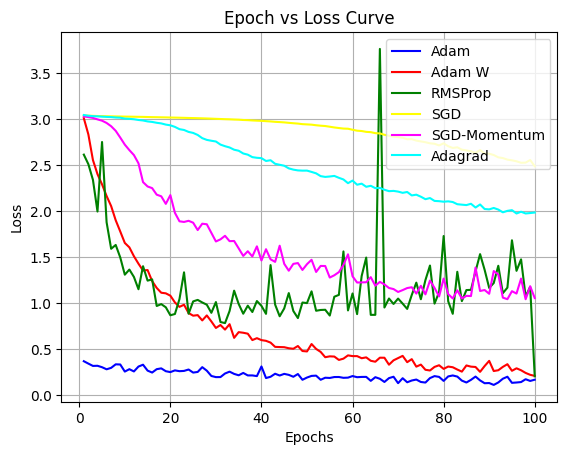

In [17]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 101)

plt.plot(epochs, l_100_adam, label="Adam", color="blue")
plt.plot(epochs, l_100_adamW, label="Adam W", color="red")
plt.plot(epochs, l_100_RMSprop, label="RMSProp", color="green")
plt.plot(epochs, l_100_SGD, label="SGD", color="yellow")
plt.plot(epochs, l_100_SGD_Momentum, label="SGD-Momentum", color="magenta")
plt.plot(epochs, l_100_adagrad, label="Adagrad", color="cyan")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss Curve")

plt.legend()
plt.grid(True)

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


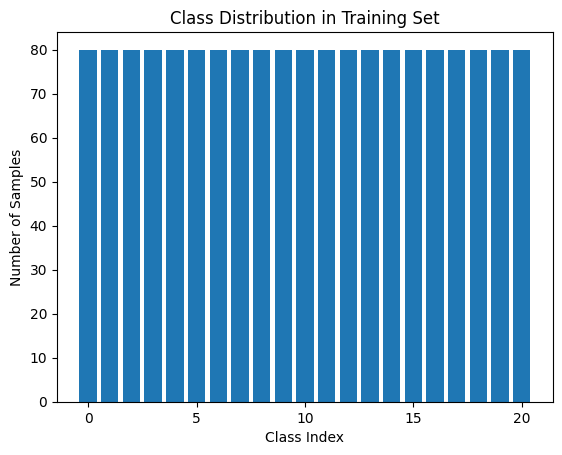

In [ ]:
#Checking fo imbalance if any
import numpy as np
import matplotlib.pyplot as plt

class_counts = np.array([train_generator.classes.tolist().count(i) for i in range(num_classes)])
plt.bar(range(num_classes), class_counts)
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()


There is no class imbalance and there is no overfit yet either


In [ ]:
# Generalizing the model
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)


Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


In [ ]:
#rm -rf /content/UCMerced_LandUse/test

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3), name="conv2d_1"),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu", name="conv2d_2"),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu", name="conv2d_3"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")  # Output layer
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("CNN Model Created!")
model.summary()


CNN Model Created!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,307,349 (12.62 MB)

 Trainable params: 3,307,349 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 25

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

print("Training Completed!")


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.6498 - loss: 1.0586
✅ Test Accuracy: 0.66


Generalizing the model and increasing the number of epochs has increased the accuracy somewhat.


In [ ]:
EPOCHS = 40

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

print("Training Completed!")


Increasing only the epochs

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.7499 - loss: 0.7907
Test Accuracy: 0.76


In [ ]:
EPOCHS = 90

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

print("Training Completed!")


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8055 - loss: 0.7482
Test Accuracy: 0.79


In [ ]:
pip install grad-cam


# **GRAD CAM**

In [ ]:
import torch
import torchvision
import torch.nn as nn
import os
from torchvision.transforms import transforms

import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import matplotlib.pyplot as plt

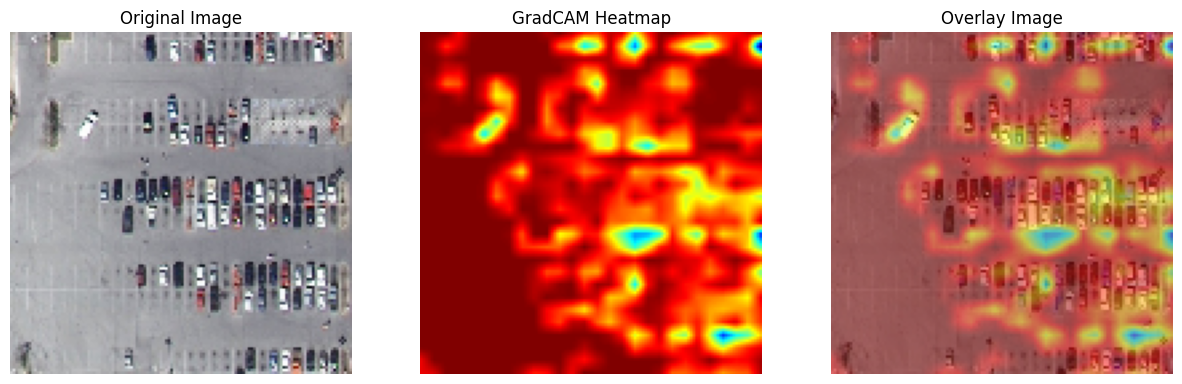

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
import tensorflow as tf

# Load and preprocess the image
img_path = "/content/UCMerced_LandUse/test/parkinglot/parkinglot19.tif"
img = image.load_img(img_path, target_size=(128, 128))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# 15 is the category for parking lot, needs to be changed for different classes
score = CategoricalScore([15])
gradcam = Gradcam(model, clone=True)

# GRAD-CAM on the layer before the last one
cam = gradcam(score, img_array, penultimate_layer="conv2d_3")

heatmap = np.uint8(255 * cam[0])
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# For creating overlay of the heatmap on the original image
overlay_img = cv2.addWeighted(np.uint8(255 * img_array[0]), 0.5, heatmap, 0.5, 0)
original_image = np.uint8(255 * img_array[0])
original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
overlay_img = cv2.addWeighted(original_image_bgr, 0.5, heatmap, 0.5, 0)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.uint8(255 * img_array[0]))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("GradCAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay_img)
plt.title("Overlay Image")
plt.axis("off")
plt.show()


In [ ]:
cv2.imwrite("original_image1.png", original_image_bgr)
cv2.imwrite("gradcam_heatmap1.png", heatmap)
cv2.imwrite("overlay_image1.png", overlay_img)

True